# Example of Birth-Death diagram on various datasets

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from datasets import dataset_factories
from stats import collect_edge_statistics, collect_node_statistics
from common import train_val_test_split_dataframe, set_theme


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Matplotlib settings
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False


## Example 1: HighSchool Dataset


We start by loading the data into two objects:
- An "events" dataframe containing the events (it should have three columns "src","dst", "t")
- a "Nodes" dataframe containing the node-level information

In [21]:
dataset_name="highschool" # Can be replaced with "wikipedia","lastfm","reddit","CanParl","Contacts","enron","Flights","mooc","SocialEvo","UNtrade","UNvote","USLegis".
ds_loader = dataset_factories[dataset_name]
events, nodes = ds_loader().values()



We then split the datasets into train and test by assigning a label "split"  to each of them. 

In [17]:

train_val_test_split_dataframe(events, 0, 0.15)
t_split = events.test_time
events.reset_index(inplace=True)

events.head()


,split,t,src,dst,datetime,date,t_scaled
0,train,1353303380,153,164,2012-11-19 07:36:20,2012-11-19,0.000000
1,train,1353303400,153,158,2012-11-19 07:36:40,2012-11-19,0.000027
2,train,1353303640,153,164,2012-11-19 07:40:40,2012-11-19,0.000356
3,train,1353303760,154,167,2012-11-19 07:42:40,2012-11-19,0.000521
4,train,1353303840,149,155,2012-11-19 07:44:00,2012-11-19,0.000631


Now we can use two functions to calculate the statistics (number of events, min and max time of interactions etc...) at the node and edge level.

"rank" indicates the rank of the node/edge in order of arrival in the graph. 

In [19]:

df_node = collect_node_statistics(events)
df_edge = collect_edge_statistics(events)

df_node.head()

,t_min,t_max,node_count,n_as_src,n_as_dst,rank
node,,,,,,
153,1353303380,1354024740,1912,1887,25,0
164,1353303380,1354028540,779,208,571,1
158,1353303400,1354024820,2660,1294,1366,2
154,1353303760,1354024520,2074,1910,164,3
167,1353303760,1354024620,1132,605,527,4


"edge_key" is a unique identifier of the node pairs (src,dst)

In [20]:
df_edge.head()

,t_min,t_max,edge_count,src,dst,rank
edge_key,,,,,,
27049,1353303380,1353907380,6,153,164,0
25117,1353303400,1354024680,413,153,158,1
28043,1353303760,1354024520,205,154,167,2
24174,1353303840,1353484900,4,149,155,3
30449,1353304000,1354017120,28,173,174,4


/tmp/ipykernel_2993756/3817970982.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


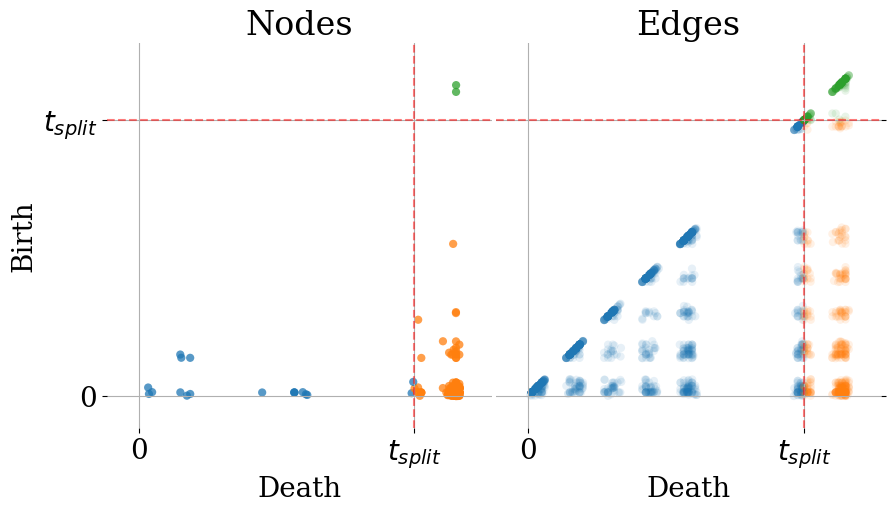

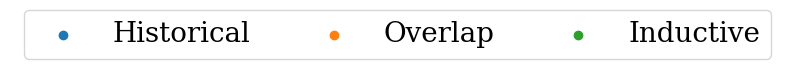

In [22]:

mintime = min([df["t_min"].min() for df in [df_node, df_edge]])
maxtime = max([df["t_max"].max() for df in [df_node, df_edge]])
margin = 0.1

box_lim = (
    mintime - margin * (maxtime - mintime),
    maxtime + margin * (maxtime - mintime),
)

fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 5),
    sharex=True,
    sharey=True,
    # Reduce space between subplots
    gridspec_kw={"wspace": 0.01},
)
for df, ax, label in zip([df_node, df_edge], axs, ["Nodes", "Edges"]):
    ax.set(adjustable="box", aspect="equal")
    # Not used at the moment, seaborn doesn't like to convert datetime in a nice way
    # for field in ["t_max", "t_min"]:
    #     df[field + "_dt"] = pd.to_datetime(df[field], unit='s')

    ax.axvline(t_split, color="r", linestyle="--", alpha=0.5)
    ax.axhline(t_split, color="r", linestyle="--", alpha=0.5)

    df["split"] = "Overlap"
    df.loc[df["t_max"] < t_split, "split"] = "Historical"
    df.loc[df["t_min"] > t_split, "split"] = "Inductive"

    sns.scatterplot(
        data=df,
        x="t_max",
        y="t_min",
        hue="split",
        hue_order=["Historical", "Overlap", "Inductive"],
        palette="tab10",
        edgecolor="none",
        ax=ax,
        # alpha=0.1 if label == "Edges" else 0.3,
        alpha=min(
            10 * np.power(1 / len(df), 0.5) * (1 if label == "Nodes" else 0.5), 1
        ),
        s=35,
        rasterized=True,
        # s=1 / len(df_edge) * 1e5,
    )

    ax.set_xlabel("Death")
    ax.set_title(label)
    labels = ["0", "$t_{split}$"]
    ax.set_xticks(ticks=[mintime, t_split])
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks=[mintime, t_split])
    ax.set_yticklabels(labels)

    ax.set_xlim(*box_lim)
    ax.set_ylim(*box_lim)
    if label == "Nodes":
        ax.set_ylabel("Birth")
        ax.yaxis.tick_left()
    if label == "Edges":
        ax.set_ylabel(None)
        ax.yaxis.tick_right()
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# plt.suptitle(f"Birth-Death Diagram on {dataset_name}")
output_path = f"figures/birthdeath_train_test_split/{dataset_name}.pdf"
os.makedirs("figures/birthdeath_train_test_split", exist_ok=True)
plt.tight_layout()
plt.savefig(output_path, bbox_inches="tight", dpi=300)
# Separate legend
_, ax_legend = plt.subplots(figsize=(10, 0.5))
# Increase size object

ax_legend.legend(
    handles,
    labels,
    loc="center",
    ncol=3,
)
ax_legend.axis("off")
# plt.savefig(
#     f"figures/birthdeath_train_test_split/legend.pdf", bbox_inches="tight", dpi=300
# )
plt.show()


# main("mooc")

# Example 2: A user-item graph 

/tmp/ipykernel_2993756/2214470080.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["split"] = "Overlap"
/tmp/ipykernel_2993756/2214470080.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["split"] = "Overlap"
/tmp/ipykernel_2993756/2214470080.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


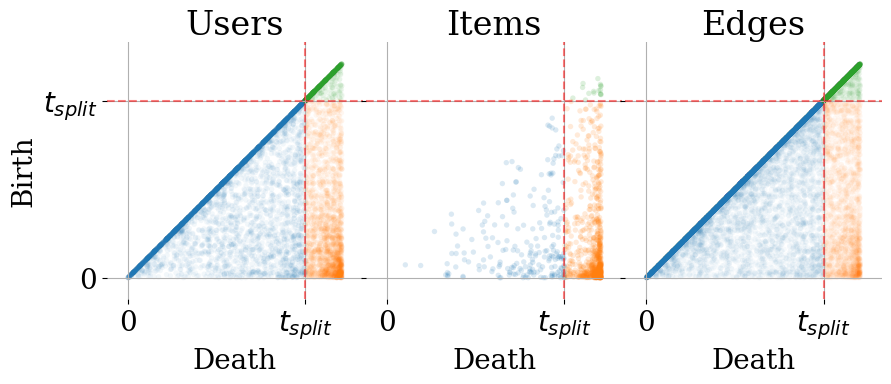

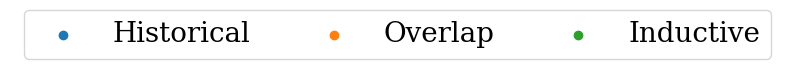

In [25]:

# sns.set_theme(style="whitegrid", font="serif", font_scale=1.5)
# Remove grid
bipartite_datasets = [
    # "mooc", 
                    #   "reddit", 
                      "wikipedia", 
                    #   "lastfm",
                      ]

# directed_datasets = ["uci", "UNTrade", "Flights", "Enron"]
# undirected_datasets = ["SocialEvo", "Contacts", "UNvote", "USLegis", "highschool"]

dataset_name = "reddit"
for dataset_name in bipartite_datasets:
    scale = 5e5

    ds_loader = dataset_factories[dataset_name]
    events, nodes = ds_loader().values()

    train_val_test_split_dataframe(events, 0, 0.15)
    t_split = events.test_time

    events.reset_index(inplace=True)
    df_node = collect_node_statistics(events)

    df_src = df_node[df_node["n_as_src"] > 0]
    df_dst = df_node[df_node["n_as_dst"] > 0]

    df_edge = collect_edge_statistics(events)

    mintime = min([df["t_min"].min() for df in [df_node, df_edge]])
    maxtime = max([df["t_max"].max() for df in [df_node, df_edge]])
    margin = 0.1

    box_lim = (
        mintime - margin * (maxtime - mintime),
        maxtime + margin * (maxtime - mintime),
    )

    fig, axs = plt.subplots(
        1,
        3,
        figsize=(10, 5),
        sharex=True,
        sharey=True,
        # Reduce space between subplots
        gridspec_kw={"wspace": 0.01},
    )
    for df, ax, label in zip(
        [df_src, df_dst, df_edge], axs, ["Users", "Items", "Edges"]
    ):
        ax.set(adjustable="box", aspect="equal")
        # Not used at the moment, seaborn doesn't like to convert datetime in a nice way
        # for field in ["t_max", "t_min"]:
        #     df[field + "_dt"] = pd.to_datetime(df[field], unit='s')

        ax.axvline(t_split, color="r", linestyle="--", alpha=0.5)
        ax.axhline(t_split, color="r", linestyle="--", alpha=0.5)

        df["split"] = "Overlap"
        df.loc[df["t_max"] < t_split, "split"] = "Historical"
        df.loc[df["t_min"] > t_split, "split"] = "Inductive"

        sns.scatterplot(
            data=df,
            x="t_max",
            y="t_min",
            hue="split",
            hue_order=["Historical", "Overlap", "Inductive"],
            palette="tab10",
            edgecolor="none",
            ax=ax,
            # alpha=0.1 if label == "Edge" else 0.3,
            alpha=min(
                10 * np.power(1 / len(df), 0.5) * (1 if label == "Node" else 0.5), 1
            ),
            s=15,
            rasterized=True,
            # s=1 / len(df_edge) * 1e5,
        )

        ax.set_xlabel("Death")
        ax.set_title(label)
        labels = ["0", "$t_{split}$"]
        ax.set_xticks(ticks=[mintime, t_split])
        ax.set_xticklabels(labels)
        ax.set_yticks(ticks=[mintime, t_split])
        ax.set_yticklabels(labels)

        ax.set_xlim(*box_lim)
        ax.set_ylim(*box_lim)
        if ax == axs[0]:
            ax.set_ylabel("Birth")
            ax.yaxis.tick_left()
        if label == "Edge":
            ax.set_ylabel(None)
            ax.yaxis.tick_right()
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    # plt.suptitle(f"Birth-Death Diagram on {dataset_name}")
    # output_path = f"figures/birthdeath_train_test_split/directed_{dataset_name}.pdf"
    os.makedirs("figures/birthdeath_train_test_split", exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches="tight", dpi=300)
    # Separate legend
    _, ax_legend = plt.subplots(figsize=(10, 0.5))
    # Increase size object

    ax_legend.legend(
        handles,
        labels,
        loc="center",
        ncol=3,
    )
    ax_legend.axis("off")
    plt.show()